In [1]:
from pocket_cube.cube import Cube
from pocket_cube.cube import Move
from heapq import heappop, heappush
from tests import *
import matplotlib.pyplot as plt
import numpy as np
import numpy
from random import choice
from typing import Dict, List, Tuple
import time
import pickle
import os


%matplotlib ipympl

In [2]:
# CONSTANTS

ALL_MOVES = list(Move)
DIRECT_MOVES = [Move.R, Move.U, Move.F]

ALL_CASES = [case1, case2, case3, case4]

In [3]:

def heuristic_1(cube: Cube):
    """Admissible heuristic for solving Cube. (Logically proved)


    Args:
        cube (Cube): Cube to calculate heuristic for.

    Returns:
        int: Estimated number of moves to reach goal.
    """
    return sum(1 for x, goal in zip(cube.state, cube.goal_state) if x != goal) / 8


In [ ]:
def test_heuristic_brute_force(heuristic, MAX_DISTANCE = 13) -> int:
    """Test if an heuristic is admissible by brute force checking most inputs
    Uses DIRECT_MOVES as it is better than ALL_MOVES cause
    we don't have as many useless cases (ex: U U' F F')
    Args:
        heuristic (function): heuristic to be tested
        MAX_DISTANCE (int, optional): Maximum number of moves. Defaults to 13.

    Returns:
        int: number of unique cubes tested

    Raises:
        AssertionError: heuristic not admissible
    """
    cube = Cube(scrambled=False)

    queue = [cube]
    min_distance = {}
    for distance in range(1, MAX_DISTANCE):
        for _ in range(3 ** (distance - 1)):
            init = queue.pop(0)
            for m in DIRECT_MOVES:
                new_cube = init.move(m)
                queue.append(new_cube)
                if new_cube.hash() not in min_distance:
                    min_distance[new_cube.hash()] = distance
                assert heuristic(new_cube) <= min_distance[new_cube.hash()]
    return len(min_distance)

In [ ]:
# Test the heuristics
# As the max value of 1st and 2nd heuristic are 3 and 4, 13 moves
# are more than enough
# 251796 possibles cubes should have been tested
test_heuristic_brute_force(heuristic_1)


In [ ]:
def test_heuristic_random_inputs(heuristic, TRIES=25000) -> int:
    """Test if an heuristic is admissible by brute force checking most inputs.
    Uses both ALL_MOVES and DIRECT_MOVES

    Args:
        heuristic (function): heuristic to be tested
        TRIES (int, optional): Number of tries per distance. Defaults to 25000.

    Returns:
        int: worse case tested (no. of faces)

    Raises:
        AssertionError: heuristic not admissible
    """
    cube = Cube(scrambled=False)

    worst_case = 0
    for distance in range(1, 25):
        for l in (ALL_MOVES, DIRECT_MOVES):
            for _ in range(TRIES):
                moves = numpy.random.choice(l, size=distance)
                new_cube = cube.move(moves.tolist())
                assert heuristic(new_cube) <= distance
                wrong_faces = sum(
                    1
                    for x, goal in zip(new_cube.state, new_cube.goal_state)
                    if x != goal
                )

                if wrong_faces > worst_case:
                    worst_case = wrong_faces
    return worst_case

In [ ]:
# Test the heuristics on random inputs
# I wanted to test for a cube with 24 wrong faces
# But I could not one set of moves to take me there.
# The third heuristic is not admissible
# Worst case should be 23 faces
test_heuristic_random_inputs(heuristic_1)


In [4]:
def test_algo(algorithm, cases, heuristics, verify_result = False, kwargs=None):
    # Run and test every case and heuristic
    TIMES = []
    STATES = []
    PATHS = []
    for heuristic in heuristics:
        if kwargs and "heuristic" in kwargs:
            kwargs["heuristic"] = heuristic
        current_times = []
        current_states = []
        current_paths = []
        for case in cases:
            cube = Cube(case)
            t_start = time.time()
            if kwargs is None:
                path, states = algorithm(cube=cube)
            else:
                path, states = algorithm(cube=cube, **kwargs)
            t_finish = time.time()

            if verify_result:
                reconstruct = cube.clone()
                for m in path:
                    reconstruct = reconstruct.move(m)
                assert numpy.array_equal(reconstruct.state, cube.goal_state)

            current_times.append(t_finish - t_start)
            current_states.append(states)
            current_paths.append(path)
        TIMES.append(current_times)
        STATES.append(current_states)
        PATHS.append(current_paths)
    return TIMES, STATES, PATHS

In [ ]:
positions = {
    0: (0, 1),
    1: (1, 1),
    2: (0, 0),
    3: (1, 0),
    4: (0 + 2, 1),
    5: (1 + 2, 1),
    6: (0 + 2, 0),
    7: (1 + 2, 0),
    8: (0 + 4, 1),
    9: (1 + 4, 1),
    10: (0 + 4, 0),
    11: (1 + 4, 0),
    12: (0 - 2, 1),
    13: (1 - 2, 1),
    14: (0 - 2, 0),
    15: (1 - 2, 0),
    16: (0, 1 + 2),
    17: (1, 1 + 2),
    18: (0, 0 + 2),
    19: (1, 0 + 2),
    20: (0, 1 - 2),
    21: (1, 1 - 2),
    22: (0, 0 - 2),
    23: (1, 0 - 2),
}

def distance_heuristic(cube: Cube) -> int:
    base_coords = np.array([(0, 1), (1, 1), (0, 0), (1, 0)])
    offsets = np.array([[0, 0], [1, 0], [2, 0], [-1, 0], [0, 1], [0, -1]]) * 2

    idx = 0
    sum = 0
    for i, x in enumerate(cube.state):
        if x != cube.goal_state[i]:
            idx = 4 * x
            while cube.state[idx] != cube.goal_state[idx + 1]:
                idx+=1
            p1 = positions[4 * x]
            p2 = positions[idx]
            sum += abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    return sum


In [5]:
def construct_road_astar(cube: Cube, road: Dict[str, Tuple[Cube, int, Move]]) -> List:
    """Construct the result path for A*

    Args:
        cube (Cube): End solved cubed
        road (Dict[str, Tuple[Cube, int, Move]]): Dictionary of nodes

    Returns:
        List: Path to solve the cube
    """
    p, _, m = road[cube.hash()]
    path = []
    while m:
        path.append(m)
        p, _, m = road[p.hash()]
    path.reverse()
    return path

def astar(cube: Cube, heuristic) -> Tuple[List, int]:
    """A* algorithm to solve a cube

    Args:
        cube (Cube): Input cube
        h (function): Heuristic function to use

    Returns:
        Tuple(List, int): The path and the number of states
    """

    # Priority queue: (COST, HASH, CUBE)
    frontier = []
    heappush(frontier, (0 + heuristic(cube), cube.hash(), cube.clone()))
    # Road as dict of  node -> (parent, cost, move)
    road = {cube.hash(): (None, 0, None)}
    no_states = 0
    curr_cube: Cube

    # While unexplored nodes
    while frontier:
        # Take current cube
        _, _, curr_cube = heappop(frontier)
        no_states += 1
        c = road[curr_cube.hash()][1]

        # If solution was found, return result
        if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
            return construct_road_astar(curr_cube, road), no_states

        # Create new node for every new possible cube
        for m in Move:
            tentative_cube = curr_cube.move(m)
            tentative_cube_hash = tentative_cube.hash()
            tentative = heuristic(tentative_cube)

            if tentative_cube_hash not in road:
                heappush(frontier, (c + 1 + tentative, tentative_cube_hash, tentative_cube))
                road[tentative_cube_hash] = (curr_cube, c + 1, m)

    return [], no_states

In [6]:
# Run A*
cube = Cube(case3)
path, astar_states = astar(cube, heuristic_1)

17881


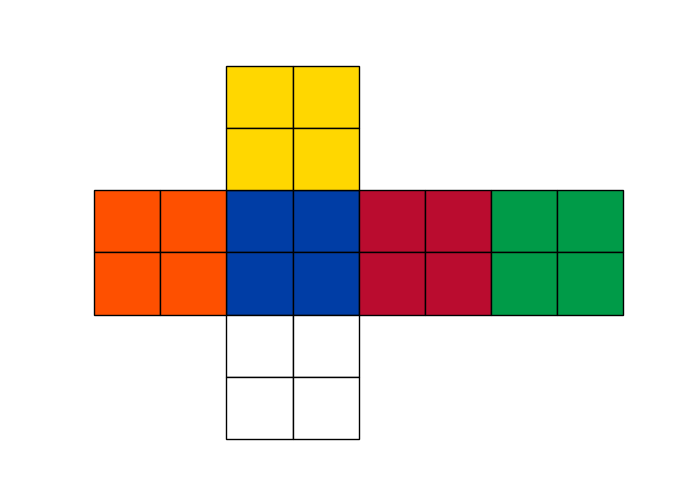

In [7]:
# Verify A*
assert path is not None

reconstruct = cube.clone()
for m in path:
    reconstruct = reconstruct.move(m)
plt.close("all")
print(astar_states)
reconstruct.render()

assert numpy.array_equal(reconstruct.state, cube.goal_state)

In [8]:
# Run and test every case and heuristic for A*

# Check if the file exists
if os.path.exists('astar_data.pkl'):
    # Load the variables
    with open('astar_data.pkl', 'rb') as f:
        ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB = pickle.load(f)
else:
    # Run and test every case and heuristic for A*
    ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB = test_algo(astar, ALL_CASES, [heuristic_1], True, {"heuristic": None})

    # Save the variables
    with open('astar_data.pkl', 'wb') as f:
        pickle.dump((ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB), f)

print(ASTAR_TIMES_PDB)
print(ASTAR_STATES_PDB)
print(ASTAR_PATHS_PDB)

[[0.03672933578491211, 0.41899776458740234, 6.383136034011841, 75.11601305007935]]
[[74, 1084, 17881, 213246]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.U: 2>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.Fp: 4>], [<Move.R: 0>, <Move.Fp: 4>, <Move.R: 0>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.Up: 5>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.F: 1>, <Move.Up: 5>]]]


In [9]:
def construct_road_bfs(
    common_state: Cube,
    road_to_common_state: Dict[str, Tuple[Cube, Move]],
    road_to_end: Dict[str, Tuple[Cube, Move]],
) -> List:
    # Create the road from input to common state
    p1, m1 = road_to_common_state[common_state.hash()]
    road = []
    while m1:
        road.append(m1)
        p1, m1 = road_to_common_state[p1.hash()]
    road.reverse()

    # Create the road from common state to input
    p2, m2 = road_to_end[common_state.hash()]
    road_rev = []
    while m2:
        road_rev.append(m2.opposite())
        p2, m2 = road_to_end[p2.hash()]

    return road + road_rev


def bfs_bidirectional(cube: Cube) -> Tuple[List, int]:
    curr_cube: Cube
    curr_cube_reversed: Cube

    direction = 1
    cube = cube.clone()
    queue = [cube]
    discovered = {cube.hash(): (0, cube)}
    road = {cube.hash(): (None, None)}

    cube_reversed = cube.clone()
    aux = cube_reversed.state
    cube_reversed.state = cube_reversed.goal_state
    cube_reversed.goal_state = aux
    queue_reverse = [cube_reversed]

    discovered_reversed = {cube_reversed.hash(): (0, cube_reversed)}
    reversed_road = {cube_reversed.hash(): (None, None)}

    no_states = 0
    while queue and queue_reverse:
        if direction:
            curr_cube = queue.pop(0)
            no_states += 1

            _, common_cube = discovered_reversed.get(cube.hash(), (0, None))
            c, _ = discovered[curr_cube.hash()]

            if common_cube:
                return construct_road_bfs(common_cube, road, reversed_road), no_states

            for m in Move:
                tentative_cube = curr_cube.move(m)
                tentative_cube_hash = tentative_cube.hash()
                if discovered.get(tentative_cube_hash, None) is None:
                    queue.append(tentative_cube)
                    discovered[tentative_cube_hash] = (c + 1, tentative_cube)
                    road[tentative_cube_hash] = (curr_cube, m)
        else:
            curr_cube_reversed = queue_reverse.pop(0)
            no_states += 1

            _, common_cube = discovered.get(curr_cube_reversed.hash(), (False, None))
            c, _ = discovered_reversed[curr_cube_reversed.hash()]

            if common_cube:
                return construct_road_bfs(common_cube, road, reversed_road), no_states

            for m in Move:
                tentative_cube = curr_cube_reversed.move(m)
                tentative_cube.goal_state = curr_cube_reversed.goal_state
                tentative_cube_hash = tentative_cube.hash()
                if discovered_reversed.get(tentative_cube_hash, None) is None:
                    queue_reverse.append(tentative_cube)
                    discovered_reversed[tentative_cube_hash] = (c + 1, tentative_cube)
                    reversed_road[tentative_cube_hash] = (curr_cube_reversed, m)

        direction = direction ^ 1
    return [], no_states

In [10]:
# Run BFS
cube = Cube(case3)
road, bfs_no_states = bfs_bidirectional(cube)

1016


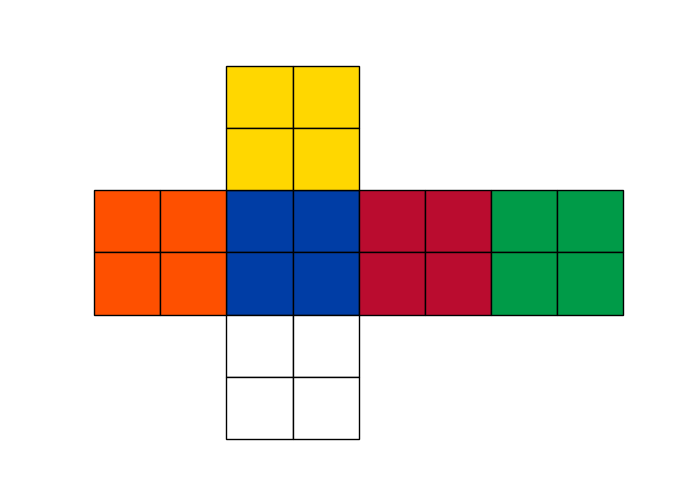

In [11]:
# Verify BFS

# Test road from input to end
reconstruct = cube.clone()
for m in road:
    reconstruct = reconstruct.move(m)
plt.close("all")
print(bfs_no_states)
reconstruct.render()

assert numpy.array_equal(reconstruct.state, cube.goal_state)

In [12]:
# Run and test every case and heuristic for BFS_BIDIRECTIONAL
# BFS is so fast there is no point to save results to file
BFS_TIMES, BFS_STATES, BFS_PATHS = test_algo(bfs_bidirectional, ALL_CASES, [None], True)

print(BFS_TIMES)
print(BFS_STATES)
print(BFS_PATHS)

[[0.04554176330566406, 0.09410834312438965, 0.2888069152832031, 1.1129271984100342]]
[[110, 242, 1016, 3880]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.U: 2>, <Move.F: 1>, <Move.Up: 5>, <Move.Rp: 3>, <Move.Up: 5>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.R: 0>, <Move.Up: 5>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.U: 2>, <Move.F: 1>, <Move.R: 0>], [<Move.R: 0>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.F: 1>, <Move.Up: 5>, <Move.F: 1>, <Move.Up: 5>, <Move.Up: 5>, <Move.F: 1>, <Move.Up: 5>]]]


In [48]:
def big_faces_heuristic(cube: Cube) -> int:
    wrong_faces = sum(1 for x, goal in zip(cube.state, cube.goal_state) if x != goal)

    if wrong_faces == 8:
        return 1
    if wrong_faces == 15:
        return 3
    if wrong_faces < 8:
        return 2
    return wrong_faces / 1.7

In [14]:
cube = Cube(scrambled=False)
sum(1 for x, goal in zip(cube.state, cube.goal_state) if x != goal)

0

In [15]:
from math import log, sqrt

class Node:
    def __init__(self, cube: Cube, parent=None, parent_action=None):
        self.cube = cube
        self.state = cube.state
        self.goal_state = cube.goal_state
        self.parent = parent
        self.parent_action = parent_action
        self.children = []
        self._number_of_visits = 0
        self._rewards = 0
        self._untried_actions = list(Move)
        self._tried_actions = []
        return

    def is_fully_expanded(self):
        # Check if all possible moves have been tried
        return len(self._untried_actions) == 0

    def is_final(self):
        return numpy.array_equal(self.state, self.goal_state)

def select_move(
    node: Node,
    c,
) -> Node:
    max = 0
    result = None
    child: Node
    for child in node.children:
        ucb = child._rewards / child._number_of_visits + c * sqrt(2 *
            log(node._number_of_visits) / child._number_of_visits
        )
        if ucb > max:
            max = ucb
            result = child

    return result

def construct_road_monte_carlo(node: Node) -> List:
    path = []
    while node.parent_action:
        path.append(node.parent_action)
        node = node.parent
    path.reverse()
    return path

def monte_carlo(cube: Cube, budget: int, C: float, heuristic) -> Cube:
    tree = Node(cube)

    for i in range(budget):
        # Start from root
        node = tree

        # SELECTION
        # Go down the tree until leaf or not fully expanded node
        while not node.is_final() and node.is_fully_expanded():
            node = select_move(node, C)

        # Return the first solution found
        if node.is_final():
            return construct_road_monte_carlo(node), i

        # EXPANSION
        # Create new node
        if not node.is_final():
            move = choice(node._untried_actions)
            node._untried_actions.remove(move)
            node._tried_actions.append(move)
            new_cube = node.cube.move(move)

            child = Node(new_cube, node, move)
            node.children.append(child)
            node = child

        # If the new node is a solution, return it
        if node.is_final():
            return construct_road_monte_carlo(node), i

        # ROLLOUT
        # Simulate game until timeout or solution
        timeout = 14
        curr_cube = node.cube.clone()
        best_found = heuristic(curr_cube)
        while not numpy.array_equal(curr_cube.state, curr_cube.goal_state) and timeout > 0:
            curr_cube = curr_cube.move(choice(ALL_MOVES))
            tentative = heuristic(curr_cube)
            # Select best
            if tentative < best_found:
                best_found = tentative
            timeout -= 1

        best_found = 14 - best_found
        reward = 0.1 * best_found
        # Back propagation
        while node is not None:
            node._number_of_visits += 1
            node._rewards += reward
            node = node.parent

    return [], budget

In [54]:
# Run Monte Carlo
cube = Cube(case2)
monte_carlo_path, monte_no_states = monte_carlo(cube, 20000, 0.5, big_faces_heuristic)

6876


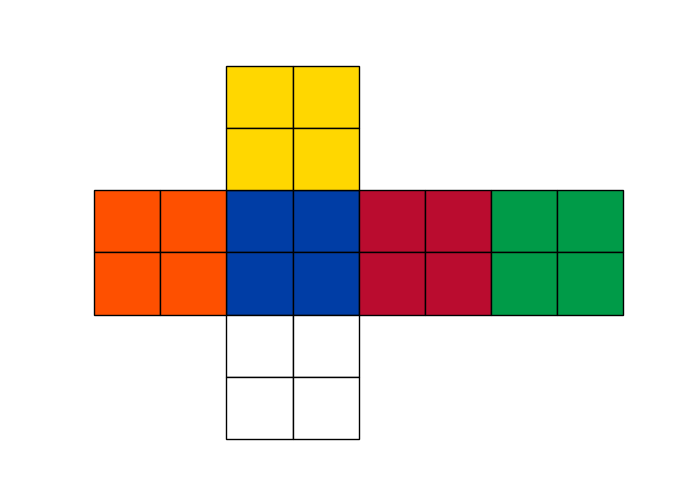

In [55]:
plt.close("all")
reconstruct = cube.clone()
for move in monte_carlo_path:
    reconstruct = reconstruct.move(move)
print(monte_no_states)
reconstruct.render()

assert numpy.array_equal(reconstruct.state, cube.goal_state)

In [68]:
def test_monte_carlo(heuristics):
    if os.path.exists("mcts_data.pkl"):
        # Load the variables
        with open("mcts_data.pkl", "rb") as f:
            (
                MCTS_TIMES_ALL_BUDGETS,
                MCTS_STATES_ALL_BUDGETS,
                MCTS_PATHS_ALL_BUDGETS
            ) = pickle.load(f)
    else:
        MCTS_TIMES_ALL_BUDGETS = {}
        MCTS_STATES_ALL_BUDGETS = {}
        MCTS_PATHS_ALL_BUDGETS = {}

        for budget in [1000, 5000, 10000, 20000]:
            for c in [0.5, 0.1]:
                for _ in range(20):
                    MCTS_TIMES, MCTS_STATES, MCTS_PATHS = test_algo(
                        monte_carlo,
                        ALL_CASES,
                        [heuristic_1, big_faces_heuristic],
                        False,
                        {
                            "budget": budget,
                            "C": c,
                            "heuristic": None,
                        },
                    )

                    # Add MCTS_TIMES to previous value from dict
                    if (budget, c) in MCTS_TIMES_ALL_BUDGETS:
                        MCTS_TIMES_ALL_BUDGETS[(budget, c)] = [
                            [a + b for a, b in zip(x, y)]
                            for x, y in zip(MCTS_TIMES_ALL_BUDGETS[(budget, c)], MCTS_TIMES)
                        ]
                    else:
                        MCTS_TIMES_ALL_BUDGETS[(budget, c)] = MCTS_TIMES

                    # Add MCTS_STATES to previous value from dict
                    if (budget, c) in MCTS_STATES_ALL_BUDGETS:
                        MCTS_STATES_ALL_BUDGETS[(budget, c)] = [
                            [a + b for a, b in zip(x, data)]
                            for x, data in zip(MCTS_STATES_ALL_BUDGETS[(budget, c)], MCTS_STATES)
                        ]
                    else:
                        MCTS_STATES_ALL_BUDGETS[(budget, c)] = MCTS_STATES

                    # Add MCTS_PATHS to previous value from dict
                    if (budget, c) in MCTS_PATHS_ALL_BUDGETS:
                        MCTS_PATHS_ALL_BUDGETS[(budget, c)] = [
                            [a + len(path) for a, path in zip(x, data)]
                            for x, data in zip(MCTS_PATHS_ALL_BUDGETS[(budget, c)], MCTS_PATHS)
                        ]
                    else:
                        MCTS_PATHS_ALL_BUDGETS[(budget, c)] = [[len(path) for path in data] for data in MCTS_PATHS]

        # # Divide all values in MCTS_TIMES_ALL_BUDGETS by 20
        for key in MCTS_TIMES_ALL_BUDGETS:
            MCTS_TIMES_ALL_BUDGETS[key] = [[value / 20 for value in sublist] for sublist in MCTS_TIMES_ALL_BUDGETS[key]]

        # # Divide all values in MCTS_STATES_ALL_BUDGETS by 20
        for key in MCTS_STATES_ALL_BUDGETS:
            MCTS_STATES_ALL_BUDGETS[key] = [[value / 20 for value in sublist] for sublist in MCTS_STATES_ALL_BUDGETS[key]]

        # # Divide all values in MCTS_PATHS_ALL_BUDGETS by 20
        for key in MCTS_PATHS_ALL_BUDGETS:
            MCTS_PATHS_ALL_BUDGETS[key] = [[value / 20  for value in sublist] for sublist in MCTS_PATHS_ALL_BUDGETS[key]]

        # Save the variables
        with open("mcts_data.pkl", "wb") as f:
            pickle.dump(
                (
                    MCTS_TIMES_ALL_BUDGETS,
                    MCTS_STATES_ALL_BUDGETS,
                    MCTS_PATHS_ALL_BUDGETS
                ),
                f,
            )
    return MCTS_TIMES_ALL_BUDGETS, MCTS_STATES_ALL_BUDGETS, MCTS_PATHS_ALL_BUDGETS
MCTS_TIMES_ALL_BUDGETS, MCTS_STATES_ALL_BUDGETS, MCTS_PATHS_ALL_BUDGETS = test_monte_carlo([heuristic_1, big_faces_heuristic])

In [70]:
print(MCTS_TIMES_ALL_BUDGETS)
print(MCTS_STATES_ALL_BUDGETS)
print(MCTS_PATHS_ALL_BUDGETS)

{(1000, 0.5): [[1.101529598236084, 1.4538480043411255, 1.0038957595825195, 1.0217434167861938], [1.0172827243804932, 0.9371210336685181, 0.9277040958404541, 0.976563572883606]], (1000, 0.1): [[0.9681682586669922, 1.0235635042190552, 0.881967306137085, 0.9036380052566528], [0.8802758455276489, 0.9206265211105347, 1.01249361038208, 0.9365414381027222]], (5000, 0.5): [[1.9695568084716797, 4.485959529876709, 4.574558615684509, 4.396936058998108], [4.1282639503479, 3.2098538875579834, 4.288347244262695, 4.4685012102127075]], (5000, 0.1): [[2.965207576751709, 4.2794846296310425, 4.540251016616821, 4.367963075637817], [2.783794641494751, 2.6565855741500854, 4.686689376831055, 4.495305418968201]], (10000, 0.5): [[4.562123894691467, 8.643374681472778, 8.69305169582367, 8.641444444656372], [3.288083553314209, 5.995117545127869, 8.815496683120728, 8.826186656951904]], (10000, 0.1): [[0.9243267774581909, 7.188612341880798, 8.693355798721313, 8.580088019371033], [8.872786402702332, 4.84316170215606

In [59]:
def create_pattern_database():
    PATTERN_DATABASE = {}
    cube = Cube(scrambled=False)
    PATTERN_DATABASE[cube.hash()] = 0

    queue = [cube]
    for distance in range(1, 8):
        for _ in range(6 ** (distance - 1)):
            init = queue.pop(0)
            for m in Move:
                new_cube = init.move(m)
                queue.append(new_cube)
                if new_cube.hash() not in PATTERN_DATABASE:
                    PATTERN_DATABASE[new_cube.hash()] = distance
    return PATTERN_DATABASE

In [60]:
PATTERN_DATABASE = create_pattern_database()

In [32]:
def new_heuristic(cube: Cube):
    return PATTERN_DATABASE.get(cube.hash(), heuristic_1(cube))

def new_heuristic_alone(cube: Cube):
    return PATTERN_DATABASE.get(cube.hash(), 14)

In [28]:
# Test pattern database

ALL_MOVES = list(Move)

def test_new_heuristic(moves):
    # Since we are using random moves, we might end up with a sequence
    # That could be solved in less moves
    assert new_heuristic(Cube(moves)) <= len(moves)

for _ in range(1000):
    for distance in range(1, 8):
        moves = [choice(ALL_MOVES) for _ in range(distance)]
        test_new_heuristic(moves)

# Some static test cases
assert new_heuristic(Cube('R U')) == 2
assert new_heuristic(Cube('R U R')) == 3
assert new_heuristic(Cube('R U F R U')) == 5

In [30]:
# Run A* with PATTERN heuristic
cube = Cube(case4)
path, states = astar(cube, new_heuristic)

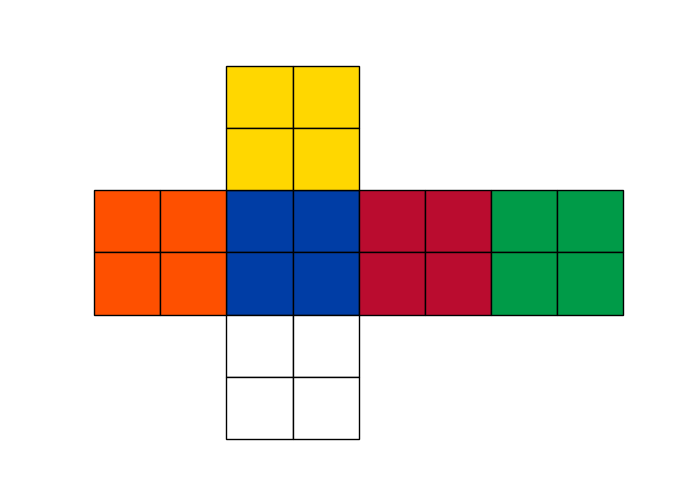

In [31]:
reconstruct = cube.clone()
for m in path:
    reconstruct = reconstruct.move(m)

plt.close("all")
reconstruct.render()
assert numpy.array_equal(reconstruct.state, cube.goal_state)

In [73]:
# Run and test every case and PATTER_DB heuristic for A*

# Check if the file exists
if os.path.exists("astar_data_pdb.pkl"):
    # Load the variables
    with open("astar_data_pdb.pkl", "rb") as f:
        ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB = pickle.load(f)
else:
    # Run and test every case and heuristic for A*
    ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB = test_algo(
        astar, ALL_CASES, [new_heuristic, new_heuristic_alone], True, {"heuristic": None}
    )

    # Save the variables
    with open("astar_data_pdb.pkl", "wb") as f:
        pickle.dump((ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB), f)

print(ASTAR_TIMES_PDB)
print(ASTAR_STATES_PDB)
print(ASTAR_PATHS_PDB)

[[0.006008148193359375, 0.24791288375854492, 8.105004787445068, 100.31087327003479], [0.0033223628997802734, 0.0023779869079589844, 0.0029823780059814453, 0.02176809310913086]]
[[6, 523, 18241, 226180], [6, 8, 10, 70]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.U: 2>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.Fp: 4>], [<Move.U: 2>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Fp: 4>, <Move.R: 0>, <Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.F: 1>]], [[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.U: 2>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>, <Move.Up: 5>, <Move.R: 0>, <Move.F: 1>, <Move.Up: 5>, <Move.Fp: 4>], [<Move.U: 2>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 

In [39]:
plt.close("all")

# Run Monte Carlo
cube = Cube(case2)
monte_carlo_path, monte_no_states = monte_carlo(cube, 20000, 0.5, new_heuristic_alone)

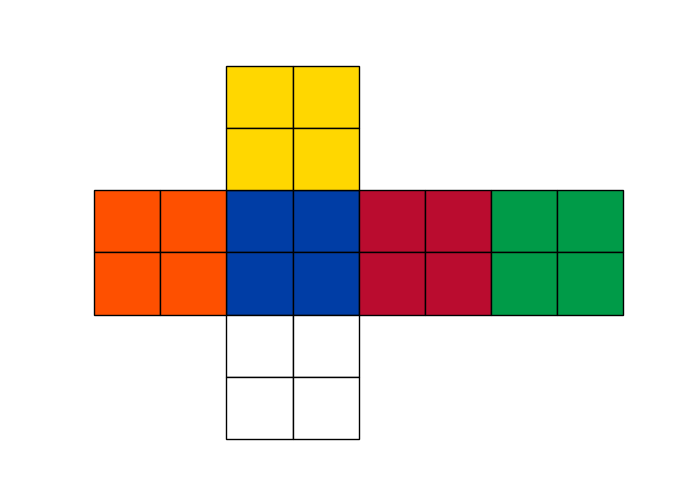

In [40]:
reconstruct = cube.clone()
for m in monte_carlo_path:
    reconstruct = reconstruct.move(m)

plt.close("all")
reconstruct.render()
assert numpy.array_equal(reconstruct.state, cube.goal_state)